In [1]:
import os
import sys
import multiprocessing as mp
import pickle
from pathlib import Path
import wandb
import torch
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

In [2]:
%load_ext autoreload
%autoreload 2

# Load model as artifact from WandB

In [3]:
run = wandb.init()
artifact = run.use_artifact('asm_detect/ASM_seg_sweep/model-kln2uxue:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kayan (asm_detect). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-kln2uxue:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.8


In [4]:
print(artifact_dir)

/n/home07/kayan/asm/notebooks/artifacts/model-kln2uxue:v0


In [5]:
artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-kln2uxue:v0"

In [6]:
# create new version of state dict with keys matching unet model
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:5] == "model":
        name = k[6:] # remove `model.`
        new_state_dict[name] = v

In [7]:
# same parameters as trained model
backbone = "resnet18"
weights = True
in_channels=4
num_classes=2

# load model
model = Unet(encoder_name=backbone,
            encoder_weights="imagenet" if weights is True else None,
            in_channels=in_channels,
            classes=num_classes,
            )
model.load_state_dict(new_state_dict)

<All keys matched successfully>

# Run inference

In [8]:
# datamodule parameters
root = "/n/holyscratch01/tambe_lab/kayan/karena/"
batch_size = 64
num_workers = 1
mines_only = False
split = False
split_n = None
split_path = "/n/home07/kayan/asm/data/splits/split_670487"
save_split = False

In [9]:
# get test dataloader from datamodule
datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                           root=root, transforms=min_max_transform, mines_only=mines_only, split_path=split_path)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()

In [12]:
# Put model on evaluation mode and load to local device
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Direct image-wide prediction with global averaging

In [13]:
test_pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            test_pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45


In [51]:
def pixelwise_to_prob(pixelwise_preds):
    class_proba = {}
    for (unique_id,preds) in pixelwise_preds.items():
        # average probability
        class_proba[unique_id] = np.mean(preds)
        #class_proba[unique_id] = np.mean(preds*(preds>0.01))
        #class_proba[unique_id] = np.sum((preds>0.5))
    return class_proba

In [52]:
class_proba = pixelwise_to_prob(test_pixelwise_predictions)

In [22]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [53]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

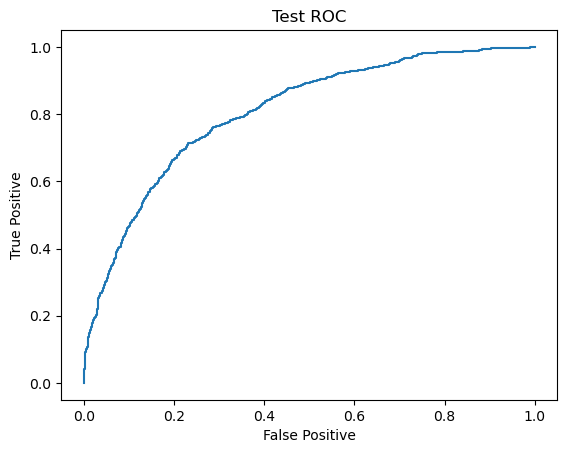

In [54]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [55]:
roc_auc_score(true_labels, class_proba)

0.8065704585547984

# To train conv layer

In [ ]:
train_pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(train_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            train_pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

In [9]:
val_pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(val_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            val_pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34


# Train convolutional layer

In [14]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in train_pixelwise_predictions.keys()]

In [16]:
len(labels)/sum(labels)

4.734888653234359

In [17]:
len(labels)/(len(labels)-sum(labels))

1.2677455990914253

In [91]:
# training parameters
batch_size = 64
lr = 0.0001
n_epoch = 10
class_weights = torch.Tensor([1/6,5/6]).to(device)

In [20]:
inputs = np.array(list(train_pixelwise_predictions.values()))

In [21]:
tensor_inputs = torch.Tensor(inputs)
tensor_inputs = tensor_inputs[:, None, :, :]
tensor_labels = torch.LongTensor(labels)

In [92]:
dataset = TensorDataset(tensor_inputs,tensor_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [93]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

conv_model = ConvNet().to(device)

In [94]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(conv_model.parameters(), lr=lr)

In [95]:
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = conv_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #wandb.log({'training_loss': running_loss / 100})
            running_loss = 0.0

[1,   100] loss: 0.613
[2,   100] loss: 0.511
[3,   100] loss: 0.511
[4,   100] loss: 0.497
[5,   100] loss: 0.510
[6,   100] loss: 0.505
[7,   100] loss: 0.500
[8,   100] loss: 0.501
[9,   100] loss: 0.503
[10,   100] loss: 0.497


# Test performance

In [42]:
data_dir = "/n/home07/kayan/asm/data/"
suffix = "_focal"
with open(data_dir+"test_seg_preds"+suffix, 'rb') as handle:
    test_pixelwise_predictions = pickle.load(handle)

In [43]:
test_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] 
               for x in test_pixelwise_predictions.keys()]

In [44]:
test_inputs = np.array(list(test_pixelwise_predictions.values()))

In [45]:
tensor_test_inputs = torch.Tensor(test_inputs)
tensor_test_inputs = tensor_test_inputs[:, None, :, :]
tensor_test_labels = torch.LongTensor(test_labels)

In [46]:
test_dataset_conv = TensorDataset(tensor_test_inputs,tensor_test_labels)

In [96]:
test_dataloader_conv = DataLoader(test_dataset_conv, batch_size=batch_size)

In [97]:
class_proba = []
true_labels = []
for i, (images, labels) in enumerate(test_dataloader_conv):
    images = images.to(device)
    outputs = torch.softmax(conv_model(images),dim=-1).cpu().detach()
    class_proba.extend(outputs[:,1].tolist())
    true_labels.extend(labels.tolist())

# ROC Curve

Text(0, 0.5, 'True Positive')

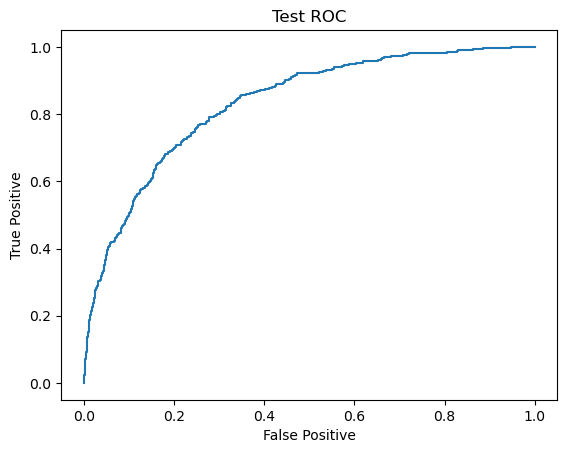

In [98]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [99]:
roc_auc_score(true_labels, class_proba)

0.8323801489049641

# Convert pixelwise predictions to image-wide label

In [11]:
def pixelwise_to_prob(pixelwise_preds):
    class_proba = {}
    for (unique_id,preds) in pixelwise_preds.items():
        # average probability
        class_proba[unique_id] = np.mean(preds)
        #class_proba[unique_id] = np.mean(preds*(preds>0.5))
        #class_proba[unique_id] = np.sum((preds>0.5))
    return class_proba

In [12]:
class_proba = pixelwise_to_prob(pixelwise_predictions)

In [13]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [14]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

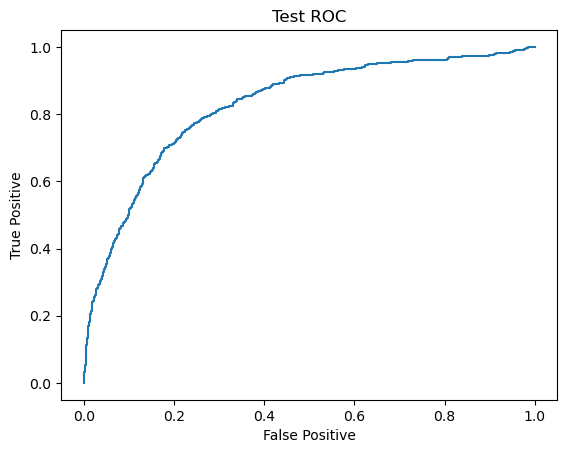

In [15]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [16]:
roc_auc_score(true_labels, class_proba)

0.8277890160837248

## Investigating predictions

In [17]:
true_labels[0:10]

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [18]:
list(pixelwise_predictions.keys())[0:10]

['lat_-1--745__lon_33--985',
 'lat_1--965__lon_27--345',
 'lat_-1--315__lon_26--495',
 'lat_7--735__lon_-11--935',
 'lat_0--785__lon_29--115',
 'lat_4--185__lon_16--045',
 'lat_-8--175__lon_26--865',
 'lat_8--635__lon_-11--265',
 'lat_9--685__lon_-12--285',
 'lat_-6--755__lon_19--835']

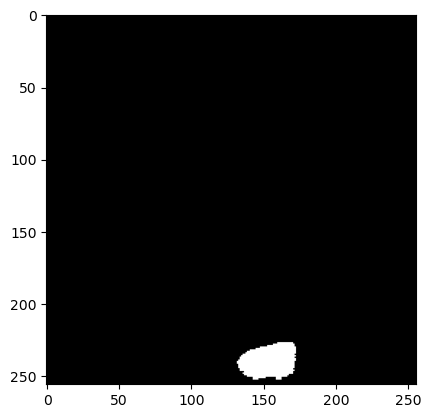

In [20]:
plt.imshow(pixelwise_predictions['lat_7--735__lon_-11--935']>0.3,cmap="gray")

In [10]:
data_dir = "/n/home07/kayan/asm/data/"
suffix = "_focal"
with open(data_dir+"val_seg_preds"+suffix, 'wb') as handle:
    pickle.dump(val_pixelwise_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test Lightning module 

In [51]:
n_epoch = 5
class_weights = [1/6,5/6]
lr = 0.0001
weight_decay = 0.01

In [13]:
# device configuration
device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", len(os.sched_getaffinity(0)))
workers = len(os.sched_getaffinity(0))
print(f"Running on {num_devices} {device}(s) with {workers} cpus")

Running on 1 cuda(s) with 4 cpus


In [16]:
# ---PREPARE DATA---
data_dir = "/n/home07/kayan/asm/data/"
suffix = "_focal"
with open(data_dir+"train_seg_preds"+suffix, 'rb') as handle:
    train_pixelwise_predictions = pickle.load(handle)
with open(data_dir+"val_seg_preds"+suffix, 'rb') as handle:
    val_pixelwise_predictions = pickle.load(handle)
with open(data_dir+"test_seg_preds"+suffix, 'rb') as handle:
    test_pixelwise_predictions = pickle.load(handle)

In [21]:
# datamodule configuration
batch_size = 64

# set up dataloaders
train_dataloader = get_conv_dataloader(train_pixelwise_predictions, batch_size=batch_size, split="train")
val_dataloader = get_conv_dataloader(val_pixelwise_predictions, batch_size=batch_size, split="val")
test_dataloader = get_conv_dataloader(test_pixelwise_predictions, batch_size=batch_size, split="test")

In [52]:
model = LightningConvNet(class_weights=class_weights, lr=lr, weight_decay=weight_decay)

In [53]:
trainer = Trainer(
            accelerator=device,
            devices=num_devices,
            max_epochs=n_epoch,
            logger=None
        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-94df735d-54d3-575a-b9cd-d15faa82c62f]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ConvNet          | 138 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.554     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [55]:
trainer.test(model=model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-94df735d-54d3-575a-b9cd-d15faa82c62f]
/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5809119939804077     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5809119939804077}]

In [57]:
class_proba = []
true_labels = []
for i, (images, labels) in enumerate(test_dataloader):
    images = images.to(device)
    outputs = torch.softmax(model.to(device)(images),dim=-1).cpu().detach()
    class_proba.extend(outputs[:,1].tolist())
    true_labels.extend(labels.tolist())

Text(0, 0.5, 'True Positive')

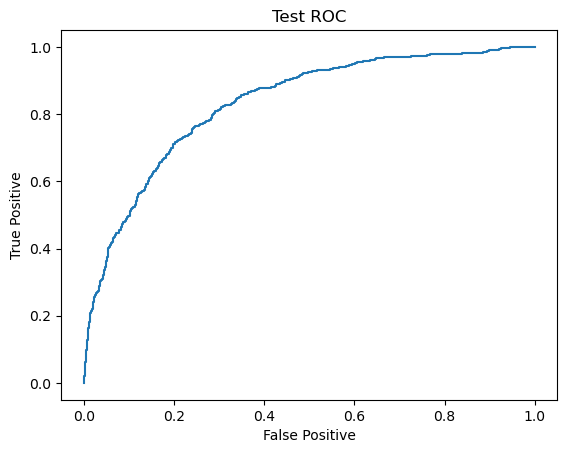

In [58]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [59]:
roc_auc_score(true_labels, class_proba)

0.8315007644119621